In [3]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [4]:
all_data = pd.read_csv(r'C:\Users\Gebruiker\Documents\thesiscode\experimental\Preprocessed_datasets\preprocessed_wine.csv', index_col=0)
errors = all_data['errors']
clustering_features_preprocessed = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

In [5]:
# Scaling the features 
to_scale = clustering_features_preprocessed.columns
clustering_features_preprocessed[to_scale] = StandardScaler().fit_transform(clustering_features_preprocessed[to_scale])

clustering_features_preprocessed[:5]

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
12  0.687846   -0.160373  0.141557          -0.694417  -0.834587   
23 -0.356751   -0.343481  0.502356          -0.101678  -0.381526   
25 -0.124619    0.290352  2.798346           2.269277   1.808272   
35  0.374467   -0.047692  0.141557           0.787430  -0.003974   
13  1.848509   -0.160373  0.075958          -2.209194  -0.683567   

    total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
12       0.004312    0.267992             -0.318793         0.017405   
23      -0.222556   -0.278564             -0.635733        -0.650337   
25       0.061029    0.155878              1.582845         0.227267   
35       0.193369    0.576306             -0.635733         0.112797   
13       0.949596    1.571320              1.160258         1.925240   

    color_intensity       hue  od280/od315_of_diluted_wines   proline  
12         0.697247  0.405843                     -0.146241  1.256507  
23        -0.367414 -0.033392                      1.394286  0.408775  
25        -0.590546  0.259431                      0.486852 -0.105424  
35         0.378486 -0.399421                      1.056636  0.144727  
13         0.569743  1.137900                     -0.504994  0.784001

In [6]:
# Functions to calculate the F-score, mean F-score and the bias of each cluster. 
# Requires with predicted and true class columns, but the errors column is not needed)
# TODO solve the "float division by zero" error
# TODO replace macro F-score by weighted F-score

def F_score(results, class_number):
    true_pos = results.loc[(results["true_class"] == class_number) & (results["predicted_class"] == class_number)]
    true_neg = results.loc[(results["true_class"] != class_number) & (results["predicted_class"] != class_number)]
    false_pos = results.loc[(results["true_class"] != class_number) & (results["predicted_class"] == class_number)]
    false_neg = results.loc[(results["true_class"] == class_number) & (results["predicted_class"] != class_number)]

    try:
        precision =  len(true_pos)/(len(true_pos) + len(false_pos))
    except ZeroDivisionError:
        return 0
    try:
        recall = len(true_pos)/(len(true_pos) + len(false_neg))
    except ZeroDivisionError:
        return 0

    try:
        f_score = 2 * ((precision * recall)/(precision + recall))
    except ZeroDivisionError:
        return 0
        
    return f_score

# Calculating the macro average F-score --> will eventually be replaced with weighted F-score
def mean_f_score(results):
    classes = results['true_class'].unique()
    class_list = []
    for i in classes:
        class_i = F_score(results, i)
        class_list.append(class_i)
    mean_f_score = (sum(class_list))/len(classes)
    print('mean F-score of all classes within this cluster in the list: ', mean_f_score)
    
    return(mean_f_score)

# Calculating the bias for each cluster
def calculate_bias(clustered_data, cluster_number):
    cluster_x = clustered_data.loc[clustered_data["clusters"] == cluster_number]
    remaining_clusters = clustered_data.loc[clustered_data["clusters"] != cluster_number]
    
# Bias definition: the lower this is, the higher the bias of cluster x is
    return mean_f_score(remaining_clusters) - mean_f_score(cluster_x)


In [7]:
# TODO: experiment with differen random states, increase number of runs
clus_model_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [8]:
# Receives the data within one cluster to calculate the variance
def calculate_variance(data):
    # Obtain errors column
    errors_col = data['errors']
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(errors_col)/n
    # Squared deviation 
    deviations = [(x - mean) ** 2 for x in errors_col]
    # Variance
    variance = sum(deviations) / n
    return variance

def get_highest_var_cluster(data):
    clusters = data['clusters'].unique()
    highest_variance = 0
    best_cluster = None
    cluster_number = None
    for i in clusters:
        print('this is i:', i)
        cluster_i = data[data['clusters'] == i]
        variance_cluster = calculate_variance(cluster_i)
        print('variance cluster:', variance_cluster)
        print('highest found variance:', highest_variance)

        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            best_cluster = cluster_i
            cluster_number = i
            print('the cluster with the highest variance:', cluster_number)

    return cluster_number


In [9]:
# plotting the cluster assignments to check whether the clusters make sense
# TODO convert clustering dimensions to PCA to plot on 2-dimensional axis 
def plot_clusters(data):
#     pca = PCA(n_components=2)
#     transformed = pd.DataFrame({"axis1": np.zeros(len(data)), "axis2" : np.zeros(len(data))})
#     transformed["axis1","axis2"] = pca.fit_transform(data.drop("clusters", axis=1), y=None)
#     transformed["clusters"] = data["clusters"]
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters")

    plt.show()
    


In [10]:
# Initialisation: all instances are assigned to the same cluster
# TODO check the true_class column as it has no labels with the class =2
clustering_features_preprocessed['clusters'] = 1
clustering_features = clustering_features_preprocessed.copy(deep=True)

clustering_features.head()

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
12  0.687846   -0.160373  0.141557          -0.694417  -0.834587   
23 -0.356751   -0.343481  0.502356          -0.101678  -0.381526   
25 -0.124619    0.290352  2.798346           2.269277   1.808272   
35  0.374467   -0.047692  0.141557           0.787430  -0.003974   
13  1.848509   -0.160373  0.075958          -2.209194  -0.683567   

    total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
12       0.004312    0.267992             -0.318793         0.017405   
23      -0.222556   -0.278564             -0.635733        -0.650337   
25       0.061029    0.155878              1.582845         0.227267   
35       0.193369    0.576306             -0.635733         0.112797   
13       0.949596    1.571320              1.160258         1.925240   

    color_intensity       hue  od280/od315_of_diluted_wines   proline  \
12         0.697247  0.405843                     -0.146241  1.256507   
23        -0.367414 -0.033392                      1.394286  0.408775   
25        -0.590546  0.259431                      0.486852 -0.105424   
35         0.378486 -0.399421                      1.056636  0.144727   
13         0.569743  1.137900                     -0.504994  0.784001   

    clusters  
12         1  
23         1  
25         1  
35         1  
13         1

Splitting on cluster 1
this is the mean F-score of all classes within this cluster in the list:  0.5517241379310345
this is the mean F-score of all classes within this cluster in the list:  0.3125
this is the mean F-score of all classes within this cluster in the list:  0.3125
this is the mean F-score of all classes within this cluster in the list:  0.5517241379310345


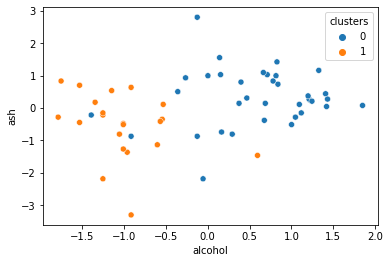

this is i: 0
variance cluster: 0.24305555555555547
highest found variance: 0
the cluster with the highest bias: 0
this is i: 1
variance cluster: 0.2358276643990929
highest found variance: 0.24305555555555547
the end
Splitting on cluster 0
this is the mean F-score of all classes within this cluster in the list:  0.5362637362637362
this is the mean F-score of all classes within this cluster in the list:  0.5185185185185185
this is the mean F-score of all classes within this cluster in the list:  0.5185185185185185
this is the mean F-score of all classes within this cluster in the list:  0.5362637362637362
<ipython-input-11-e08cd36d548b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.pr

In [11]:
MAX_ITER = 10 
x = 1 # cluster number
bias_prev_iteration_cluster = 0

for i in range(1, MAX_ITER):
    print('Splitting on cluster', x)
    # select the instances with cluster X as dataset
    high_bias_cluster = clustering_features.loc[clustering_features['clusters'] == x]
    high_bias_cluster.drop('clusters', axis=1)

    # Apply Kmeans 
    kmeans_algo = KMeans(n_clusters=2, **clus_model_kwargs).fit(high_bias_cluster) 
    high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(high_bias_cluster),index=high_bias_cluster.index) 
    
    new_clustering_features = clustering_features.copy(deep=True)
    new_clustering_features['clusters'] = high_bias_cluster['new_clusters'].combine_first(new_clustering_features['clusters'])
    new_clustering_features['true_class'] = all_data[['true_class']]
    new_clustering_features['predicted_class'] = all_data[['predicted_class']]

    #todo: check whether adding the predicted and true class now works
    
    # calculate bias for each of the two clusters
    negative_bias_0 = calculate_bias(new_clustering_features, 0)
    negative_bias_1 = calculate_bias(new_clustering_features, 1)

    new_clustering_features.drop(['true_class', 'predicted_class'], axis=1)

    if max(negative_bias_0, negative_bias_1) >= bias_prev_iteration_cluster:
        # select cluster with highest negative bias and merge new cluster assignments with the df
        bias_prev_iteration_cluster = max(negative_bias_0, negative_bias_1)
        clustering_features = new_clustering_features.copy(deep=True)
        plot_clusters(clustering_features)
    else:
        break
        print('no clusters with a higher bias are left')
    
    clustering_features = clustering_features.join(errors, how='left')
    x = get_highest_var_cluster(clustering_features)
    clustering_features = clustering_features.drop('errors', axis=1)
    print('the end')


In [12]:
# exporting the biased cluster dataframe for further analysis
# resulting_cluster.to_csv('biased_wine_cluster.csv')